In [1]:
#!pip install ipwhois





In [2]:

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
from ipwhois import IPWhois

# Given SFlow Format in Table 1
format = ['Type', 'sflow_agent_address', 'inputPort', 'outputPort',
               'src_MAC', 'dst_MAC', 'ethernet_type', 'in_vlan', 'out_vlan',
               'src_IP', 'dst_IP', 'IP_protocol', 'ip_tos', 'ip_ttl',
               'src_transport_port', 'dst_transport_port', 'tcp_flags',
               'packet_size', 'IP_size', 'sampling_rate', '???']

EXERCISE 4A: TOP TALKERS AND LISTENERS

In [3]:
log_df = pd.read_csv('Data_3.csv', header = None, names = format)
log_df.drop('???', axis=1, inplace = True) # Drop column with null values
log_df.head(10)

,Type,sflow_agent_address,inputPort,outputPort,src_MAC,dst_MAC,ethernet_type,in_vlan,out_vlan,src_IP,dst_IP,IP_protocol,ip_tos,ip_ttl,src_transport_port,dst_transport_port,tcp_flags,packet_size,IP_size,sampling_rate
0,FLOW,203.30.38.251,137,200,d404ff55fd4d,80711fc76001,0x0800,919,280,130.246.176.22,140.115.32.81,6,0x00,50,51216,23505,0x10,1518,1500,2048
1,FLOW,203.30.38.251,129,193,609c9f851b00,0031466b23cf,0x0800,11,919,155.69.160.32,64.233.188.128,6,0x00,56,23159,80,0x10,74,52,2048
2,FLOW,203.30.38.251,137,200,d404ff55fd4d,80711fc76001,0x0800,919,280,130.246.176.53,140.115.32.83,6,0x00,50,50041,20739,0x10,1518,1500,2048
3,FLOW,203.30.38.251,129,135,609c9f851b00,002688cd5fc7,0x0800,11,919,155.69.160.32,54.169.174.79,17,0x00,120,54241,26510,0x10,116,94,2048
4,FLOW,203.30.38.251,130,199,00239cd087c1,544b8cf9a7df,0x0800,919,600,137.132.228.15,193.62.192.8,6,0x00,56,53923,34262,0x10,70,52,2048
5,FLOW,203.30.38.251,129,135,609c9f851b00,002688cd5fc7,0x0800,11,919,155.69.160.32,54.255.221.151,17,0x00,120,55069,26509,0x10,113,91,2048
6,FLOW,203.30.38.251,130,199,00239cd087c1,544b8cf9a7df,0x0800,919,600,137.132.250.8,193.62.193.9,6,0x00,62,27419,80,0x10,58,40,2048
7,FLOW,203.30.38.251,137,200,d404ff55fd4d,80711fc76001,0x0800,919,280,193.61.196.206,140.110.147.170,6,0x00,240,443,43545,0x18,1518,1500,2048
8,FLOW,203.30.38.251,200,3,80711fc76001,00235ed9b680,0x0800,280,32,137.189.133.62,123.136.64.7,6,0x00,58,6345,34921,0x10,1342,1320,2048
9,FLOW,203.30.38.251,199,130,544b8cf9a7df,00239cd087c1,0x0800,600,919,193.62.192.8,137.132.228.15,6,0x08,55,34262,53923,0x10,1442,1420,2048


In [4]:
# Finding organisation given IP
def find_org(ip_addr):
    ip = IPWhois(ip_addr)
    result = ip.lookup_rdap()
    return result.get('network', {}).get('name')

In [5]:
# Top 5 unique IP addresses by number of packets sent
top_talkers = log_df['src_IP'].value_counts().nlargest(5).to_frame()
org = []
for ip_addr in top_talkers.index:
    org.append(find_org(ip_addr))
top_talkers['Organisation'] = org    # append org. data to the dataframe

top_talkers = top_talkers.reset_index().rename(columns = {'index':'IP Address', 
                                                        'src_IP':'No. of Packets'})
top_talkers

,No. of Packets,count,Organisation
0,193.62.192.8,3041,EUR-BIO-INST
1,155.69.160.32,2975,NTUNET1
2,130.14.250.11,2604,NLM-ETHER
3,14.139.196.58,2452,NKN-IIT-GUW
4,140.112.8.139,2056,T-NTU.EDU.TW-NET


In [6]:
# Top 5 unique IP addresses by number of packets received
top_listeners = log_df['dst_IP'].value_counts().nlargest(5).to_frame()
org = []
for ip_addr in top_listeners.index:
    org.append(find_org(ip_addr))
top_listeners['Organisation'] = org    # append org. data to the dataframe

top_listeners = top_listeners.reset_index().rename(columns = {'index':'IP Address', 
                                                        'dst_IP':'No. of Packets'})
top_listeners

,No. of Packets,count,Organisation
0,103.37.198.100,3841,A-STAR-AS-AP
1,137.132.228.15,3715,NUSNET
2,202.21.159.244,2446,RPNET
3,192.101.107.153,2368,PNNL
4,103.21.126.2,2056,IITB-IN


EXERCISE 4B: TRANSPORT PROTOCOL

In [8]:
# Create a DataFrame of packet counts per IP_protocol
packet_df = log_df['IP_protocol'].value_counts().reset_index()
packet_df.columns = ['Header Value', 'No. of Packets']

# Calculate percentage of total packets
packet_df['% total'] = packet_df['No. of Packets'] * 100 / len(log_df)

# Filter TCP (6) and UDP (17) packets
tcp_packet_df = packet_df[packet_df['Header Value'] == 6]
udp_packet_df = packet_df[packet_df['Header Value'] == 17]

# Combine the two filtered DataFrames
final_df = pd.concat([tcp_packet_df, udp_packet_df])
final_df

,Header Value,No. of Packets,% total
0,6,56064,80.818798
1,17,9462,13.639902


EXERCISE 4C: APPLICATIONS PROTOCOL

In [9]:
# Get the top 5 most common destination ports
dest_port_df = (
    log_df['dst_transport_port']
    .value_counts()
    .nlargest(5)
    .reset_index()
)

# Rename columns
dest_port_df.columns = ['Destination Port', 'No. of Packets']

# Port-to-service mapping
port_mapping = {
    45512: 'Unassigned', 
    443: 'HTTPS',
    80: 'HTTP',
    52866: 'Dynamic/Private Ports',
    56152: 'Dynamic/Private Ports',
    0: 'Reserved Port'
}

# Map ports to services, defaulting to 'Unknown' if not found
dest_port_df['Service'] = dest_port_df['Destination Port'].map(port_mapping).fillna('Unknown')

dest_port_df

,Destination Port,No. of Packets,Service
0,443,13423,HTTPS
1,80,2647,HTTP
2,52866,2068,Dynamic/Private Ports
3,45512,1356,Unassigned
4,56152,1341,Dynamic/Private Ports


EXERCISE 4D: TRAFFIC

In [10]:
total_traffic = sum(log_df['IP_size'])
total_traffic_without_sampling = total_traffic*2048

# Assuming IP_size is in number of bits
total_traffic_Mb = total_traffic_without_sampling / (pow(2, 20))
print(f"Total Traffic (Mb) = {total_traffic_Mb:.3f} Mb") 

Total Traffic (Mb) = 126519.184 Mb


EXERCISE 4E: ADDITIONAL ANALYSIS

In [11]:
# Top 5 unique communication pairs
comm_pairs_df = log_df.groupby(['src_IP', 'dst_IP']).size().sort_values(ascending = False).to_frame()
comm_pairs_df.columns = ['No. of Packets']
comm_pairs_df = comm_pairs_df.reset_index()
# comm_pairs_df

top_comm_df = comm_pairs_df[:5]
top_comm_df

,src_IP,dst_IP,No. of Packets
0,193.62.192.8,137.132.228.15,3041
1,130.14.250.11,103.37.198.100,2599
2,14.139.196.58,192.101.107.153,2368
3,140.112.8.139,103.21.126.2,2056
4,137.132.228.15,193.62.192.8,1910


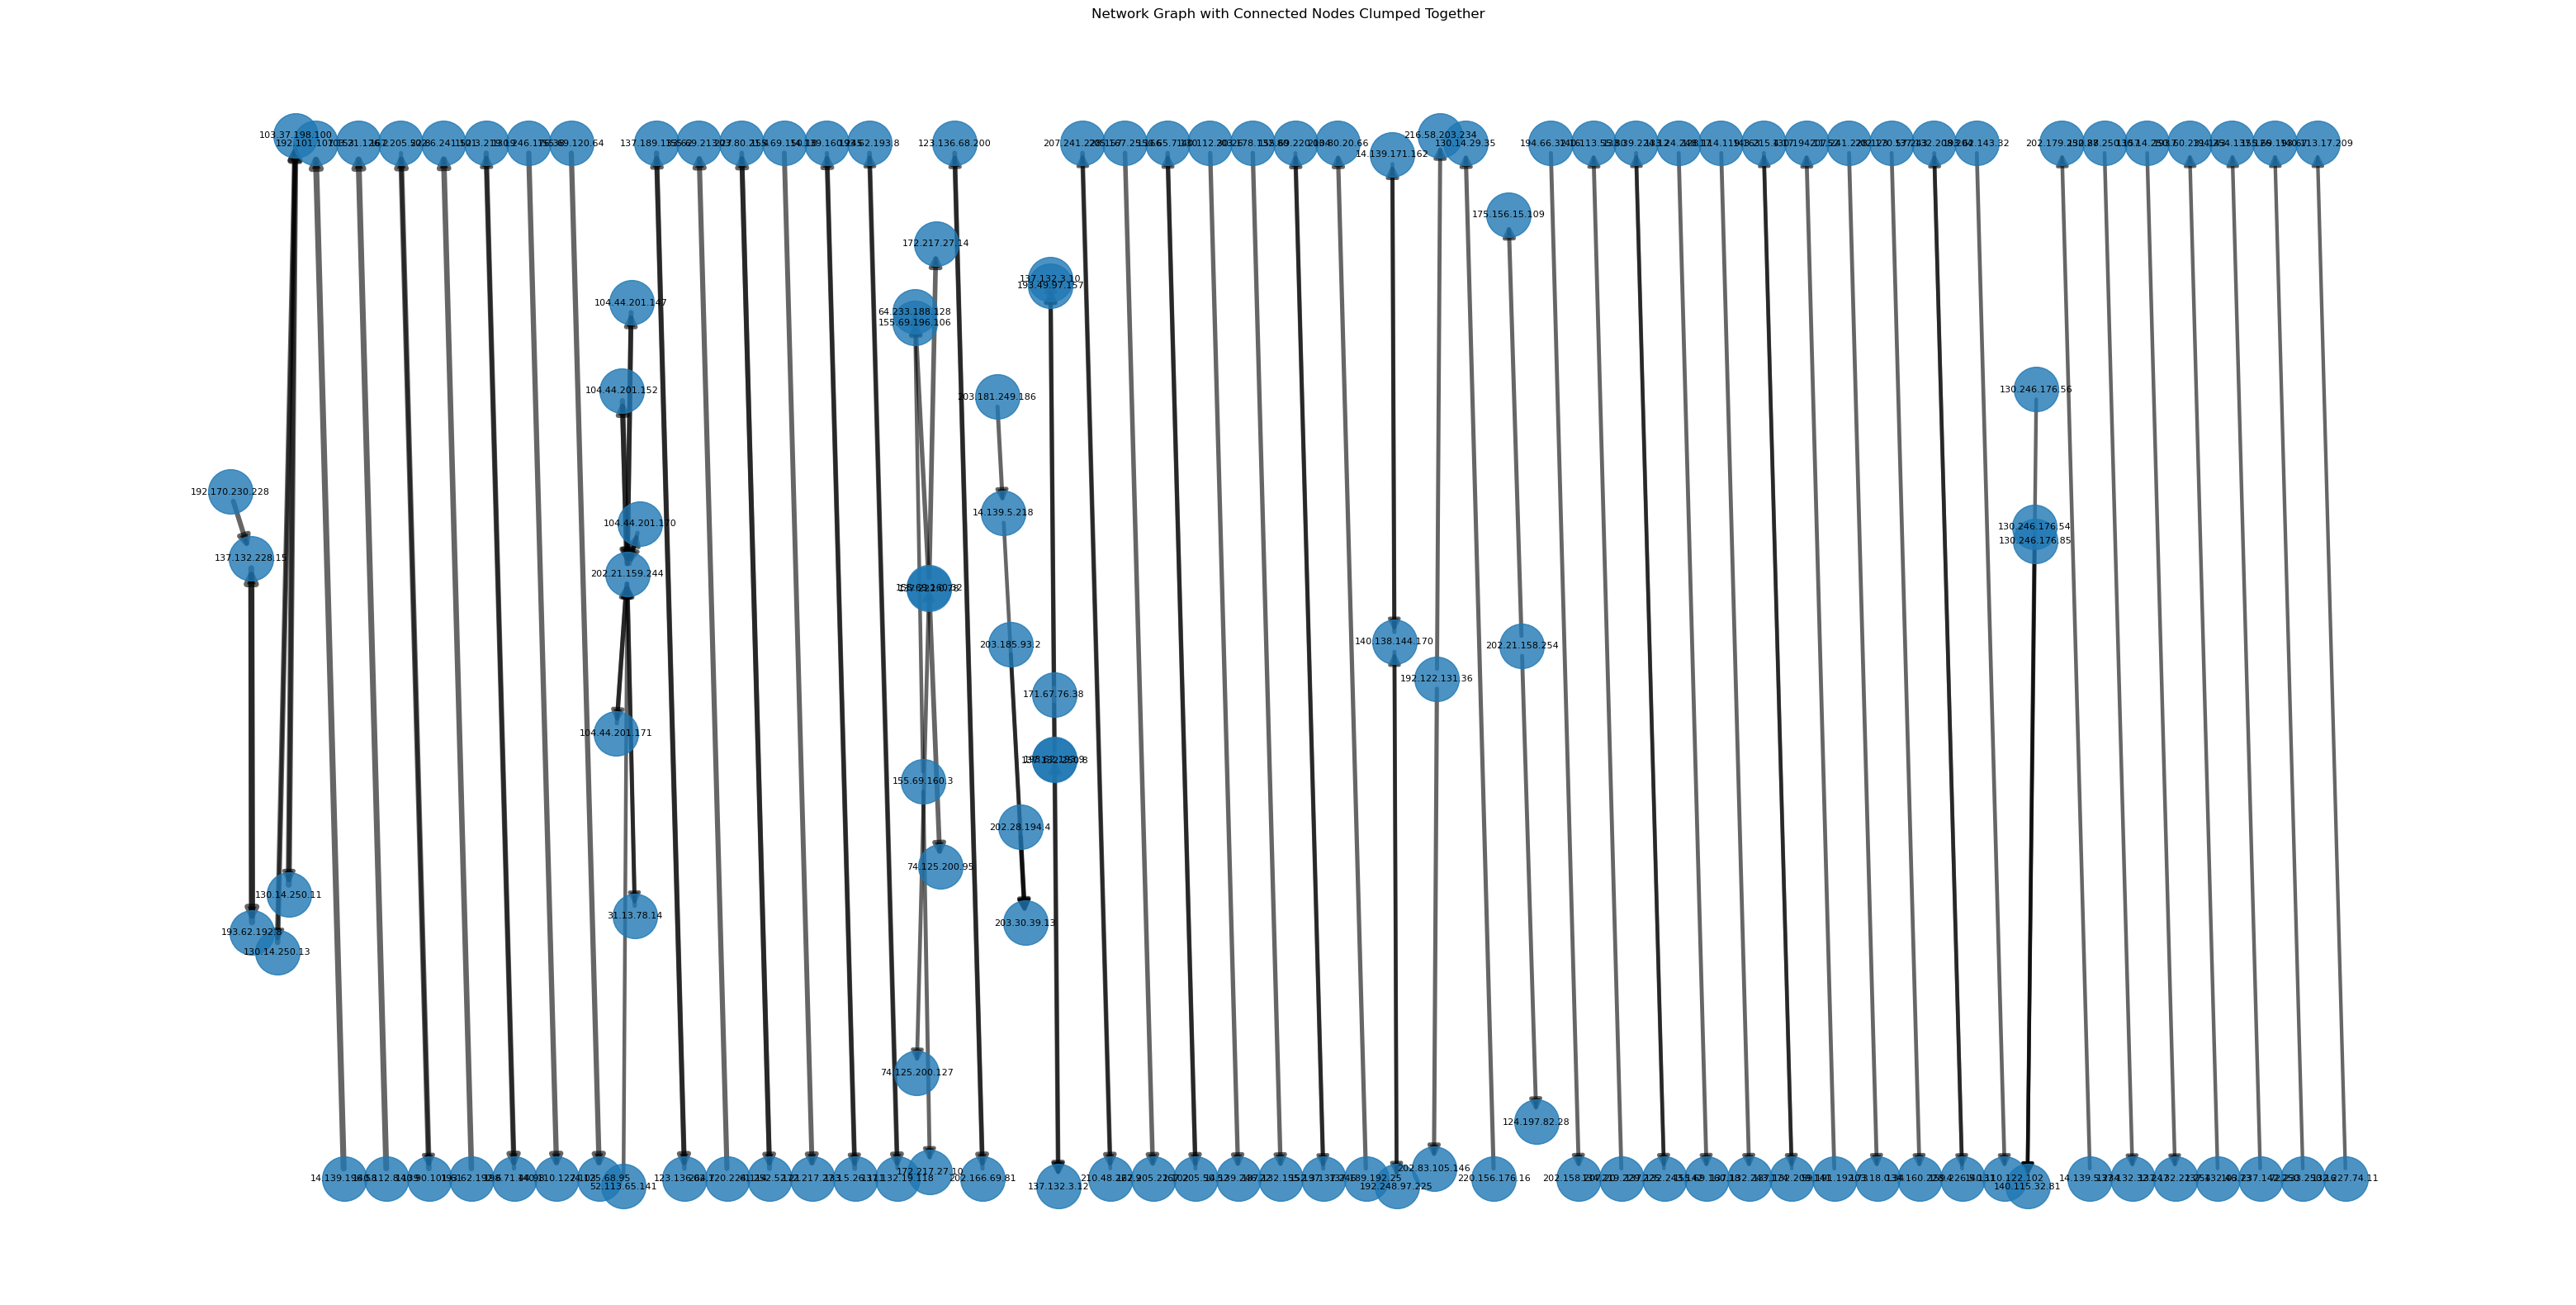

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import math

# --- Build your directed graph (G) from your data ---
graph_series = log_df.groupby(["src_IP", "dst_IP"]).size().nlargest(100)
graph_df = graph_series.to_frame().reset_index()

G = nx.DiGraph()
for _, row in graph_df.iterrows():
    G.add_edge(row['src_IP'], row['dst_IP'], weight=row[0])

# --- Get connected components (using weakly connected components for directed graphs) ---
components = list(nx.weakly_connected_components(G))
pos = {}  # To hold final positions for all nodes

# We'll arrange each component separately.
# For each component, compute a tight layout (small k) so that connected nodes are clumped.
# Then shift each component by an offset to separate them from each other.
offset_x = 0  # horizontal offset for each component
offset_y = 0  # you can also adjust vertically if you want a grid

for comp in components:
    subG = G.subgraph(comp)
    # Use a small k so that nodes in the component stay close together.
    sub_pos = nx.spring_layout(subG, k=0.3, iterations=500, seed=42)
    
    # Optionally, compute a centroid of this subgraph and shift it to (0,0) before applying an offset.
    # Here we just add the current offset.
    for node, (x, y) in sub_pos.items():
        pos[node] = (x + offset_x, y + offset_y)
    
    # Update offsets for the next component.
    # Here we shift horizontally. You might also use a grid layout for many components.
    offset_x += 3  # adjust this value as needed

# --- Plotting ---
plt.figure(figsize=(40, 20))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, alpha=0.8)

# Calculate edge widths based on weight
edge_widths = [max(math.log(data['weight'])/1.5, 0.1) for _, _, data in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6, arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network Graph with Connected Nodes Clumped Together")
plt.axis("off")
plt.show()
